# Full Waveform Inversion (FWI) Competition: Bridging Physics and Machine Learning

Description
Imagine a doctor analyzing an ultrasound scan—not just to see a blurry outline but to achieve a clearer, more detailed image crucial for an accurate diagnosis. That's the challenge geophysicists face when imaging the Earth's hidden structures. Beneath the surface lie vital resources, potential hazards, and clues to our planet's history—all requiring sharper, more precise subsurface imaging to be fully understood and effectively utilized.

Full Waveform Inversion (FWI) is the key to unlocking these secrets. This powerful technique, crucial for energy exploration, carbon storage, medical ultrasound, and advanced material testing, aims to build a detailed picture of the subsurface by analyzing the entire shape of seismic waves. But current methods are hindered by a noisy reality.

Traditional physics-based approaches are accurate, but incredibly slow and prone to errors when the signal is weak from noisy data. Pure machine learning solutions are faster, but require vast amounts of labeled data and often fail to generalize to new, unfamiliar "signal."

This competition challenges you to bridge the gap by combining physics and machine learning to advance FWI. Success here could transform not only subsurface energy exploration but also a wide range of applications, from medical diagnostics to non-destructive material testing—anywhere precise imaging matters.


In [14]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/waveform-inversion
/kaggle/input/waveform-inversion/train_samples
/kaggle/input/waveform-inversion/train_samples/FlatFault_A
/kaggle/input/waveform-inversion/train_samples/FlatVel_A
/kaggle/input/waveform-inversion/train_samples/FlatVel_A/model
/kaggle/input/waveform-inversion/train_samples/FlatVel_A/data
/kaggle/input/waveform-inversion/train_samples/CurveVel_A
/kaggle/input/waveform-inversion/train_samples/CurveVel_A/model
/kaggle/input/waveform-inversion/train_samples/CurveVel_A/data
/kaggle/input/waveform-inversion/train_samples/FlatFault_B
/kaggle/input/waveform-inversion/train_samples/Style_B
/kaggle/input/waveform-inversion/train_samples/Style_B/model
/kaggle/input/waveform-inversion/train_samples/Style_B/data
/kaggle/input/waveform-inversion/train_samples/CurveFault_B
/kaggle/input/waveform-inversion/train_samples/FlatVel_B
/kaggle/input/waveform-inversion/train_samples/FlatVel_B/model
/kaggle/input/waveform-inversion/train_samples/FlatVel_B/data
/ka

In [48]:
# Data Loading & Exploration

import numpy as np

# Load example velocity model and seismic data from FlatVel_A (change index as needed)
velocity = np.load('/kaggle/input/waveform-inversion/train_samples/FlatVel_A/model/model2.npy')
data = np.load('/kaggle/input/waveform-inversion/train_samples/FlatVel_A/data/data2.npy')

print('Velocity shape:', velocity.shape)
print('Data shape:', data.shape)

Velocity shape: (500, 1, 70, 70)
Data shape: (500, 5, 1000, 70)


Velocity shape: (500, 1, 70, 70)

500 samples
Each sample is a single-channel (1) 2D velocity model (70 x 70 grid)
Data shape: (500, 5, 1000, 70)

500 samples
Each sample has 5 channels/traces (could be receivers or sources)
Each trace is a 2D array: 1000 time steps × 70 spatial points

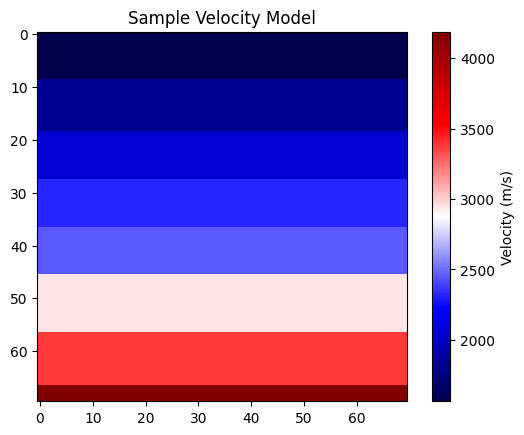

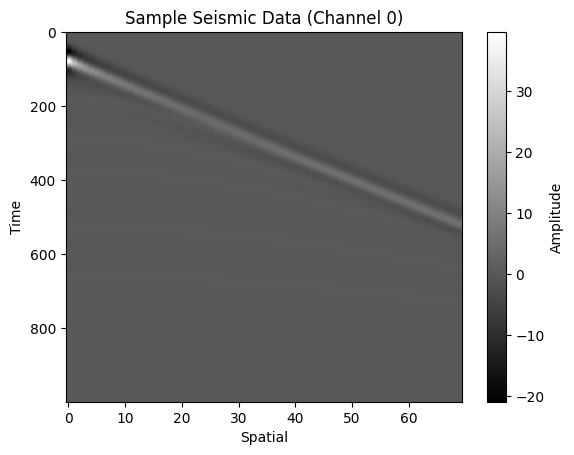

In [49]:
import matplotlib.pyplot as plt

# Visualize the first velocity model
plt.imshow(velocity[0,0], cmap='seismic')
plt.title("Sample Velocity Model")
plt.colorbar(label='Velocity (m/s)')
plt.show()

# Visualize the first seismic data trace for the first sample
plt.imshow(data[0,0], aspect='auto', cmap='gray')
plt.title("Sample Seismic Data (Channel 0)")
plt.xlabel("Spatial")
plt.ylabel("Time")
plt.colorbar(label='Amplitude')
plt.show()

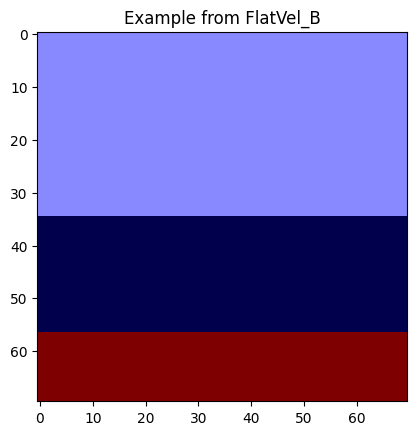

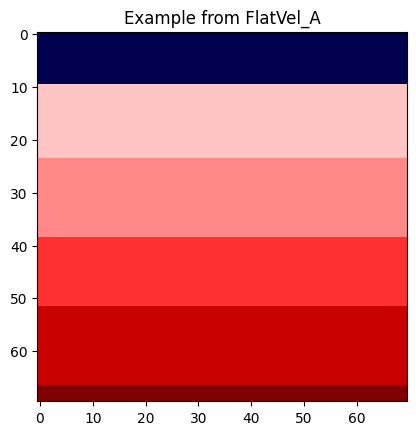

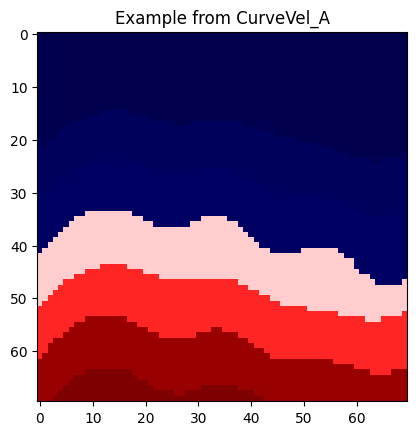

In [50]:
# Visualize a few random examples from other folders
import random

folders = [
    'FlatVel_A', 'FlatVel_B', 'CurveVel_A', 'CurveVel_B',
    'FlatFault_A', 'FlatFault_B', 'CurveFault_A', 'CurveFault_B',
    'Style_A', 'Style_B'
]

for folder in random.sample(folders, 3):
    model_dir = f'/kaggle/input/waveform-inversion/train_samples/{folder}/model'
    files = sorted(os.listdir(model_dir))
    v = np.load(os.path.join(model_dir, files[0]))
    plt.imshow(v[0, 0], cmap='seismic')
    plt.title(f'Example from {folder}')
    plt.show()

In [7]:
import numpy as np
import os

base_dir = '/kaggle/input/waveform-inversion/train_samples'
folders = [
    'FlatVel_A', 'FlatVel_B', 'CurveVel_A', 'CurveVel_B',
    'FlatFault_A', 'FlatFault_B', 'CurveFault_A', 'CurveFault_B',
    'Style_A', 'Style_B'
]

X = []
Y = []

for folder in folders:
    data_dir = os.path.join(base_dir, folder, 'data')
    model_dir = os.path.join(base_dir, folder, 'model')
    # Check if both directories exist
    if not (os.path.exists(data_dir) and os.path.exists(model_dir)):
        print(f"Skipping {folder}: missing data/model directory")
        continue
    data_files = sorted(os.listdir(data_dir))
    model_files = sorted(os.listdir(model_dir))
    for dfile, mfile in zip(data_files, model_files):
        data = np.load(os.path.join(data_dir, dfile))     # shape (500, 5, 1000, 70)
        model = np.load(os.path.join(model_dir, mfile))   # shape (500, 1, 70, 70)
        X.append(data)
        Y.append(model)

X = np.concatenate(X, axis=0)
Y = np.concatenate(Y, axis=0)

print('Total samples:', X.shape[0])
print('X shape:', X.shape)
print('Y shape:', Y.shape)

Skipping FlatFault_A: missing data/model directory
Skipping FlatFault_B: missing data/model directory
Skipping CurveFault_A: missing data/model directory
Skipping CurveFault_B: missing data/model directory
Total samples: 6000
X shape: (6000, 5, 1000, 70)
Y shape: (6000, 1, 70, 70)


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True
)

print(X_train.shape, X_val.shape)
print(Y_train.shape, Y_val.shape)

(4800, 5, 1000, 70) (1200, 5, 1000, 70)
(4800, 1, 70, 70) (1200, 1, 70, 70)


In [12]:
# Per-sample normalization (subtract mean, divide by std for each sample)
X_train = (X_train - X_train.mean(axis=(2,3), keepdims=True)) / (X_train.std(axis=(2,3), keepdims=True) + 1e-8)
X_val = (X_val - X_val.mean(axis=(2,3), keepdims=True)) / (X_val.std(axis=(2,3), keepdims=True) + 1e-8)

print(X_train[0].mean(), X_train[0].std())
print(X_train[10].mean(), X_train[10].std())
print(X_val[0].mean(), X_val[0].std())

-7.6293943e-10 1.0
-8.283343e-10 1.0
3.4877232e-10 1.0


In [13]:
print("Train mean:", X_train.mean(axis=(2,3)).mean())
print("Train std: ", X_train.std(axis=(2,3)).mean())
print("Val mean:  ", X_val.mean(axis=(2,3)).mean())
print("Val std:   ", X_val.std(axis=(2,3)).mean())

Train mean: -2.3931265e-12
Train std:  1.0
Val mean:   -1.22081685e-11
Val std:    1.0


In [ ]:
vmin, vmax = Y_train.min(), Y_train.max()
Y_train = (Y_train - vmin) / (vmax - vmin)
Y_val = (Y_val - vmin) / (vmax - vmin)

In [16]:
print("Y_train min:", Y_train.min(), "Y_train max:", Y_train.max())
print("Y_val min:", Y_val.min(), "Y_val max:", Y_val.max())

Y_train min: 1500.0 Y_train max: 4500.0
Y_val min: 1500.0 Y_val max: 4499.0


My normalization code is working correctly, and the input data is now well-scaled for deep learning. I'm ready to move forward with the next steps:

Normalize the target velocity data (if I haven’t already),

Convert the datasets into tensors using PyTorch or TensorFlow,

Set up a DataLoader to handle batching and shuffling efficiently,

And finally, begin building and training the model.

In [3]:
import numpy as np
import os

base_dir = '/kaggle/input/waveform-inversion/train_samples'
folders = [
    'FlatVel_A', 'FlatVel_B', 'CurveVel_A', 'CurveVel_B',
    'FlatFault_A', 'FlatFault_B', 'CurveFault_A', 'CurveFault_B',
    'Style_A', 'Style_B'
]

X = []
Y = []

for folder in folders:
    data_dir = os.path.join(base_dir, folder, 'data')
    model_dir = os.path.join(base_dir, folder, 'model')
    if not (os.path.exists(data_dir) and os.path.exists(model_dir)):
        print(f"Skipping {folder}: missing data/model directory")
        continue
    data_files = sorted(os.listdir(data_dir))
    model_files = sorted(os.listdir(model_dir))
    for dfile, mfile in zip(data_files, model_files):
        data = np.load(os.path.join(data_dir, dfile))
        model = np.load(os.path.join(model_dir, mfile))
        X.append(data)
        Y.append(model)

X = np.concatenate(X, axis=0)
Y = np.concatenate(Y, axis=0)
print('Total samples:', X.shape[0])
print('X shape:', X.shape)
print('Y shape:', Y.shape)

Skipping FlatFault_A: missing data/model directory
Skipping FlatFault_B: missing data/model directory
Skipping CurveFault_A: missing data/model directory
Skipping CurveFault_B: missing data/model directory
Total samples: 6000
X shape: (6000, 5, 1000, 70)
Y shape: (6000, 1, 70, 70)


In [1]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42, shuffle=True
)

NameError: name 'X' is not defined

In [ ]:
X_train = (X_train - X_train.mean(axis=(2,3), keepdims=True)) / (X_train.std(axis=(2,3), keepdims=True) + 1e-8)
X_val = (X_val - X_val.mean(axis=(2,3), keepdims=True)) / (X_val.std(axis=(2,3), keepdims=True) + 1e-8)